In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from facenet_pytorch import fixed_image_standardization
import numpy as np
import albumentations as A
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import KFold

In [2]:
import torchvision.models as models

# early-stop loss in learning rate regulation

class FaceRecognitionVGG(nn.Module):
    def __init__(self,num_classes):
        super(FaceRecognitionVGG,self).__init__()
        self.model = models.vgg19(pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,num_classes)
        )
#         num_ftrs = self.model.classifer[6].in_features
#         self.model.classifier[6] = nn.Linear(num_ftrs,num_classes)
        
    def forward(self,x):
        x = self.model.features(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.classifier(x)
        return x
    
class FaceRecognitionAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(FaceRecognitionAlexNet, self).__init__()
        self.model = models.alexnet(pretrained=True)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)
    
class FaceRecEns(nn.Module):
    def __init__(self,num_classes):
        super(FaceRecEns,self).__init__()
        self.vgg = FaceRecognitionVGG(num_classes)
        self.alexnet = FaceRecognitionAlexNet(num_classes)
    
    def forward(self,x):
        vgg_output = self.vgg(x)
        alexnet_output = self.alexnet(x)
        
        combined = (vgg_output + alexnet_output) / 2
        
        return combined
    
num_classes = 17
ensemble_model = FaceRecEns(num_classes).to('cuda')

/mnt/home/golipran/anaconda3/envs/dance-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/home/golipran/anaconda3/envs/dance-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/home/golipran/anaconda3/envs/dance-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K

In [3]:
main_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB images
])

main_dataset = torchvision.datasets.ImageFolder('Celebrity Faces Dataset',transform=main_transform)
crop_dataset = torchvision.datasets.ImageFolder('CroppedCelebs_Dataset', transform=main_transform)

In [ ]:
len(main_dataset)

In [ ]:
len(crop_dataset)

In [ ]:
main_dataset.classes

In [ ]:
crop_dataset.classes

In [ ]:
main_dataset.imgs[1000]


In [ ]:
crop_dataset.imgs[1000]

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load an image using matplotlib.image.imread
img = mpimg.imread(main_dataset.imgs[1000][0])
print(main_dataset.class_to_idx[1000][0] imgs[1000][0].)

# Plot the image using imshow
plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

SyntaxError: invalid syntax (4005308255.py, line 6)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load an image using matplotlib.image.imread
img = mpimg.imread(crop_dataset.imgs[999][0])

# Plot the image using imshow
plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

----

In [4]:
standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization
])

aug_mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.15),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   #A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.RandomSizedCrop((80,150),height=100,width=100,p=0.5),
                   A.OneOrOther(A.JpegCompression(p=0.2), A.Blur(p=0.2), p=0.66),
                   A.OneOf([
                            A.Rotate(45, p=0.3),
                            #A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5) # Change
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3),
                  A.Cutout(num_holes=8,max_h_size=8,max_w_size=8,fill_value=0,p=0.5), # Try out Cutout
                  A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2),contrast_limit=(-0.2,0.2),p=0.5),
                  A.RandomRotate90(p=0.5),
                  A.GaussianBlur(blur_limit=(3,7),p=0.5)
], p=1)

transform = {
    'train': transforms.Compose([
                                 transforms.Lambda(lambd=lambda x: aug_mask(image=np.array(x))['image']),
                                 transforms.Resize((224,224)),
                                 standard_transform
    ]),
    'test': transforms.Compose([transforms.Resize((224,224)),standard_transform])
}

/mnt/home/golipran/anaconda3/envs/dance-env/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/mnt/home/golipran/anaconda3/envs/dance-env/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:311: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/mnt/home/golipran/anaconda3/envs/dance-env/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


-----

In [13]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim

# Define your datasets and ensemble_model as provided in the code snippet

device = torch.device("cuda")

# Define data loaders
batch_size = 16  # Adjust as needed
main_loader = DataLoader(main_dataset, batch_size=batch_size, shuffle=True)#.to('cuda') # have to move it to cuda
crop_loader = DataLoader(crop_dataset, batch_size=batch_size, shuffle=True)#.to('cuda')

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble_model.parameters(), lr=0.001, momentum=0.9)  # Adjust parameters as needed

# Training function
def train(model, train_loader, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        print(epoch)
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device),data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"Epoch {epoch + 1}, Batch {i + 1}: Loss {running_loss / 100:.3f}")
                running_loss = 0.0

# Train the ensemble model
num_epochs = 5  # Adjust as needed
train(ensemble_model, main_loader, criterion, optimizer, num_epochs)
train(ensemble_model, crop_loader, criterion, optimizer, num_epochs)

0
Epoch 1, Batch 100: Loss 2.250
1
Epoch 2, Batch 100: Loss 1.418
2
Epoch 3, Batch 100: Loss 0.948
3
Epoch 4, Batch 100: Loss 0.620
4
Epoch 5, Batch 100: Loss 0.374
0
Epoch 1, Batch 100: Loss 1.362
1
Epoch 2, Batch 100: Loss 0.656
2
Epoch 3, Batch 100: Loss 0.273
3
Epoch 4, Batch 100: Loss 0.286
4
Epoch 5, Batch 100: Loss 0.145


### With Early Stop Loss

In [10]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your datasets and ensemble_model as provided in the code snippet

# Define data loaders
batch_size = 16  # Adjust as needed
main_loader = DataLoader(main_dataset, batch_size=batch_size, shuffle=True)
crop_loader = DataLoader(crop_dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble_model.parameters(), lr=0.001, momentum=0.9)  # Adjust parameters as needed

# Training function with early stopping
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=3):
    model.to(device)
    best_val_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"Epoch {epoch + 1}, Batch {i + 1}: Loss {running_loss / 100:.3f}")
                running_loss = 0.0

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.3f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
        
        print(no_improvement)
        
        if no_improvement >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
            break

    return model

# Split main_dataset into train and validation sets
train_main_dataset, val_main_dataset = train_test_split(main_dataset, test_size=0.2, random_state=42)

# Create data loaders for validation
val_main_loader = DataLoader(val_main_dataset, batch_size=batch_size, shuffle=True)

# Transform
main_loader.tranform = transform['train']
val_main_loader.transform = transform['test']

# Train the model with early stopping using the main_loader and val_main_loader
trained_model = train(ensemble_model, main_loader, val_main_loader, criterion, optimizer, num_epochs=20, patience=3)


Epoch 1
Epoch 1, Batch 100: Loss 2.254
Validation Loss: 1.308
0
Epoch 2
Epoch 2, Batch 100: Loss 1.218
Validation Loss: 0.713
0
Epoch 3
Epoch 3, Batch 100: Loss 0.642
Validation Loss: 0.325
0
Epoch 4
Epoch 4, Batch 100: Loss 0.266
Validation Loss: 0.115
0
Epoch 5
Epoch 5, Batch 100: Loss 0.113
Validation Loss: 0.063
0
Epoch 6
Epoch 6, Batch 100: Loss 0.038
Validation Loss: 0.003
0
Epoch 7
Epoch 7, Batch 100: Loss 0.004
Validation Loss: 0.060
1
Epoch 8
Epoch 8, Batch 100: Loss 0.002
Validation Loss: 0.001
0
Epoch 9
Epoch 9, Batch 100: Loss 0.001
Validation Loss: 0.000
0
Epoch 10
Epoch 10, Batch 100: Loss 0.000
Validation Loss: 0.000
0
Epoch 11
Epoch 11, Batch 100: Loss 0.000
Validation Loss: 0.000
0
Epoch 12
Epoch 12, Batch 100: Loss 0.000
Validation Loss: 0.000
0
Epoch 13
Epoch 13, Batch 100: Loss 0.000
Validation Loss: 0.000
0
Epoch 14
Epoch 14, Batch 100: Loss 0.000
Validation Loss: 0.000
0
Epoch 15
Epoch 15, Batch 100: Loss 0.000
Validation Loss: 0.000
0
Epoch 16
Epoch 16, Batch 100

### Kfold LOOCV

In [12]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import KFold

# Define your datasets and ensemble_model as provided in the code snippet

device = torch.device("cuda")

# Define data loaders
batch_size = 32  # Adjust as needed

# Concatenate both datasets
combined_dataset = torch.utils.data.ConcatDataset([main_dataset, crop_dataset])

# Define K-fold cross-validation
num_splits = 5  # Adjust as needed for k-fold
kfold = KFold(n_splits=num_splits, shuffle=True)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble_model.parameters(), lr=0.001, momentum=0.9)  # Adjust parameters as needed

# Training function
def train(model, train_loader, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device),data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"Batch {i + 1}: Loss {running_loss / 100:.3f}")
                running_loss = 0.0

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(combined_dataset)):
    print(f"Fold {fold + 1}")
    train_subset = torch.utils.data.Subset(combined_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_dataset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Train on the training set
    num_epochs = 5  # Adjust as needed
    train(ensemble_model, train_loader, criterion, optimizer, num_epochs)

    # Evaluate on the validation set (optional)
    # Perform validation or any evaluation metric computation here using val_loader


Fold 1
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Fold 2
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Fold 3
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Fold 4
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Fold 5
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


#### Kfold LOOCV on early stop loss

In [6]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import KFold

# Assuming you have a CUDA-capable device available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your datasets and ensemble_model as provided in the code snippet

# Define data loaders
batch_size = 16 #32  # Adjust as needed

# Concatenate both datasets
combined_dataset = torch.utils.data.ConcatDataset([main_dataset, crop_dataset])

# Define K-fold cross-validation
num_splits = 5  # Adjust as needed for k-fold
kfold = KFold(n_splits=num_splits, shuffle=True)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble_model.parameters(), lr=0.001, momentum=0.9)  # Adjust parameters as needed
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2,factor=0.5,verbose=True)

# Training function with early stopping
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, patience=3):
    model.to(device)
    best_val_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"Batch {i + 1}: Loss {running_loss / 100:.3f}")
                running_loss = 0.0

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)  # Move data to GPU
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

        scheduler.step(val_loss)
        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.3f}")

        # Early stopping logic
        print(f"best_val_loss: {best_val_loss}, val_loss: {val_loss}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
            break
            
        print(f"no improvements: {no_improvement}")

    return model

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(combined_dataset)):
    print(f"Fold {fold + 1}")
    train_subset = torch.utils.data.Subset(combined_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_dataset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Transform
    train_loader.tranform = transform['train']
    val_loader.transform = transform['test']
    
    # Train on the training set with early stopping
    num_epochs = 20  # Adjust as needed
    #print("started")
    trained_model = train(ensemble_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=5)

Fold 1
Epoch 1
Batch 100: Loss 1.269
Validation Loss: 0.858
best_val_loss: inf, val_loss: 0.8579141527414322
no improvements: 0
Epoch 2
Batch 100: Loss 0.534
Validation Loss: 0.762
best_val_loss: 0.8579141527414322, val_loss: 0.7619648705754015
no improvements: 0
Epoch 3
Batch 100: Loss 0.261
Validation Loss: 1.006
best_val_loss: 0.7619648705754015, val_loss: 1.0055714681330654
no improvements: 1
Epoch 4
Batch 100: Loss 0.153
Validation Loss: 0.603
best_val_loss: 0.7619648705754015, val_loss: 0.6028637178242207
no improvements: 0
Epoch 5
Batch 100: Loss 0.043
Validation Loss: 0.535
best_val_loss: 0.6028637178242207, val_loss: 0.5348667554557324
no improvements: 0
Epoch 6
Batch 100: Loss 0.008
Validation Loss: 0.587
best_val_loss: 0.5348667554557324, val_loss: 0.5871802632179525
no improvements: 1
Epoch 7
Batch 100: Loss 0.024
Validation Loss: 0.571
best_val_loss: 0.5348667554557324, val_loss: 0.570743997182904
no improvements: 2
Epoch 8
Batch 100: Loss 0.005
Validation Loss: 0.529
best

Batch 100: Loss 0.000
Validation Loss: 0.000
best_val_loss: 3.485833192876776e-05, val_loss: 3.441527976267227e-05
no improvements: 0
Epoch 13
Batch 100: Loss 0.000
Validation Loss: 0.000
best_val_loss: 3.441527976267227e-05, val_loss: 3.397819075669557e-05
no improvements: 0
Epoch 14
Batch 100: Loss 0.000
Validation Loss: 0.000
best_val_loss: 3.397819075669557e-05, val_loss: 3.354433948364506e-05
no improvements: 0
Epoch 15
Batch 100: Loss 0.000
Validation Loss: 0.000
best_val_loss: 3.354433948364506e-05, val_loss: 3.316008357817029e-05
no improvements: 0
Epoch 16
Batch 100: Loss 0.000
Validation Loss: 0.000
best_val_loss: 3.316008357817029e-05, val_loss: 3.2766556849613455e-05
no improvements: 0
Epoch 17
Batch 100: Loss 0.000
Validation Loss: 0.000
best_val_loss: 3.2766556849613455e-05, val_loss: 3.236232101042131e-05
no improvements: 0
Epoch 18
Batch 100: Loss 0.000
Validation Loss: 0.000
best_val_loss: 3.236232101042131e-05, val_loss: 3.200229169680016e-05
no improvements: 0
Epoch 

####  Test

In [7]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming the same normalization as in training
])

test_dataset = torchvision.datasets.ImageFolder('New_test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device),data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy:.2f}%")

# Test the trained ensemble model
test_model(ensemble_model, test_loader)

Accuracy on the test set: 84.85%


In [9]:
torch.save(ensemble_model.state_dict(), "ensemble_LOOCV_EarlyStop-Sched.pth")

### Training on outside testing data (Not Cropped)

In [ ]:
torch.manual_seed(0)
output = model(img_t)
print(output)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(predictClass_name)

#### Will Smith

In [38]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as imag

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

img = Image.open("WillSmith-doubleCheck.jpg")
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)
img_t = img_t.to(device)

tensor([16], device='cuda:0')
predictClass_name: Will Smith 

Class: Angelina Jolie, Confidence: 0.00%
Class: Brad Pitt, Confidence: 0.00%
Class: Denzel Washington, Confidence: 0.05%
Class: Hugh Jackman, Confidence: 0.00%
Class: Jennifer Lawrence, Confidence: 0.00%
Class: Johnny Depp, Confidence: 1.30%
Class: Kate Winslet, Confidence: 0.00%
Class: Leonardo DiCaprio, Confidence: 0.00%
Class: Megan Fox, Confidence: 0.00%
Class: Natalie Portman, Confidence: 0.00%
Class: Nicole Kidman, Confidence: 0.00%
Class: Robert Downey Jr, Confidence: 0.00%
Class: Sandra Bullock, Confidence: 0.00%
Class: Scarlett Johansson, Confidence: 0.00%
Class: Tom Cruise, Confidence: 0.00%
Class: Tom Hanks, Confidence: 0.00%
Class: Will Smith, Confidence: 98.64%


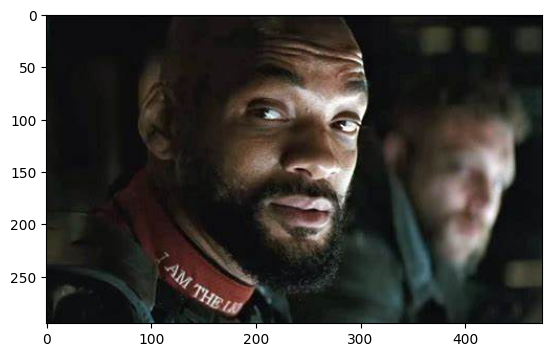

In [39]:
output = ensemble_model(img_t)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(f"predictClass_name: {predictClass_name} \n")
      
output_softmax = torch.nn.functional.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    confidence_percentage = output_softmax[0][i] * 100
    print(f"Class: {class_name}, Confidence: {confidence_percentage:.2f}%")
    
image = imag.imread('WillSmith-doubleCheck.jpg')
plt.imshow(image)

#### Denzel Washington

Denzel Washington is being viewed as Tom Cruise. Maybe have to change the augmentations to illustrate this better

tensor([5], device='cuda:0')
predictClass_name: Johnny Depp 

Class: Angelina Jolie, Confidence: 0.00%
Class: Brad Pitt, Confidence: 1.89%
Class: Denzel Washington, Confidence: 6.60%
Class: Hugh Jackman, Confidence: 0.05%
Class: Jennifer Lawrence, Confidence: 0.00%
Class: Johnny Depp, Confidence: 70.24%
Class: Kate Winslet, Confidence: 0.00%
Class: Leonardo DiCaprio, Confidence: 0.00%
Class: Megan Fox, Confidence: 0.00%
Class: Natalie Portman, Confidence: 0.00%
Class: Nicole Kidman, Confidence: 0.00%
Class: Robert Downey Jr, Confidence: 0.07%
Class: Sandra Bullock, Confidence: 0.00%
Class: Scarlett Johansson, Confidence: 0.00%
Class: Tom Cruise, Confidence: 0.00%
Class: Tom Hanks, Confidence: 0.00%
Class: Will Smith, Confidence: 21.15%


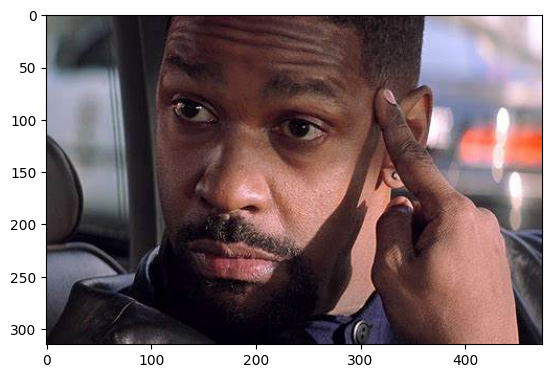

In [40]:
img = Image.open("DenzelWash-DoubleCheck.jpg")
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)
img_t = img_t.to(device)

output = ensemble_model(img_t)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(f"predictClass_name: {predictClass_name} \n")
      
output_softmax = torch.nn.functional.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    confidence_percentage = output_softmax[0][i] * 100
    print(f"Class: {class_name}, Confidence: {confidence_percentage:.2f}%")
    
image = imag.imread("DenzelWash-DoubleCheck.jpg")
plt.imshow(image)

#### Tom Cruise
Mistaken with Will Smith

tensor([16], device='cuda:0')
predictClass_name: Will Smith 

Class: Angelina Jolie, Confidence: 0.01%
Class: Brad Pitt, Confidence: 0.33%
Class: Denzel Washington, Confidence: 12.07%
Class: Hugh Jackman, Confidence: 0.07%
Class: Jennifer Lawrence, Confidence: 0.00%
Class: Johnny Depp, Confidence: 0.01%
Class: Kate Winslet, Confidence: 0.21%
Class: Leonardo DiCaprio, Confidence: 0.03%
Class: Megan Fox, Confidence: 0.01%
Class: Natalie Portman, Confidence: 0.12%
Class: Nicole Kidman, Confidence: 0.00%
Class: Robert Downey Jr, Confidence: 5.51%
Class: Sandra Bullock, Confidence: 0.60%
Class: Scarlett Johansson, Confidence: 0.00%
Class: Tom Cruise, Confidence: 0.66%
Class: Tom Hanks, Confidence: 0.77%
Class: Will Smith, Confidence: 79.60%


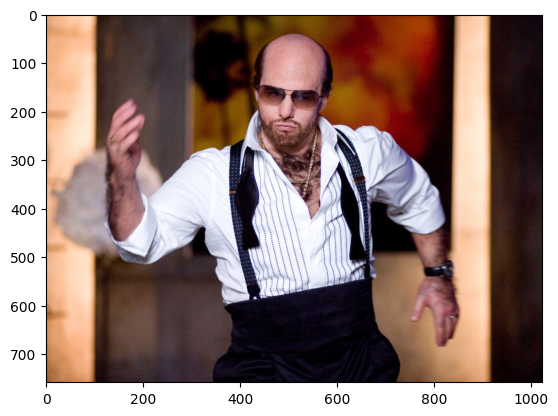

In [41]:
img = Image.open("TomCruise-DoubleCheck.jpg")
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)
img_t = img_t.to(device)

output = ensemble_model(img_t)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(f"predictClass_name: {predictClass_name} \n")
      
output_softmax = torch.nn.functional.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    confidence_percentage = output_softmax[0][i] * 100
    print(f"Class: {class_name}, Confidence: {confidence_percentage:.2f}%")
    
image = imag.imread("TomCruise-DoubleCheck.jpg")
plt.imshow(image)

#### Scarlett Johansson
Mistaken with Johnny Depp

tensor([5], device='cuda:0')
predictClass_name: Johnny Depp 

Class: Angelina Jolie, Confidence: 0.05%
Class: Brad Pitt, Confidence: 0.71%
Class: Denzel Washington, Confidence: 0.00%
Class: Hugh Jackman, Confidence: 0.00%
Class: Jennifer Lawrence, Confidence: 0.12%
Class: Johnny Depp, Confidence: 74.42%
Class: Kate Winslet, Confidence: 1.83%
Class: Leonardo DiCaprio, Confidence: 0.01%
Class: Megan Fox, Confidence: 5.05%
Class: Natalie Portman, Confidence: 0.02%
Class: Nicole Kidman, Confidence: 10.50%
Class: Robert Downey Jr, Confidence: 2.68%
Class: Sandra Bullock, Confidence: 0.37%
Class: Scarlett Johansson, Confidence: 1.20%
Class: Tom Cruise, Confidence: 0.04%
Class: Tom Hanks, Confidence: 0.00%
Class: Will Smith, Confidence: 2.99%


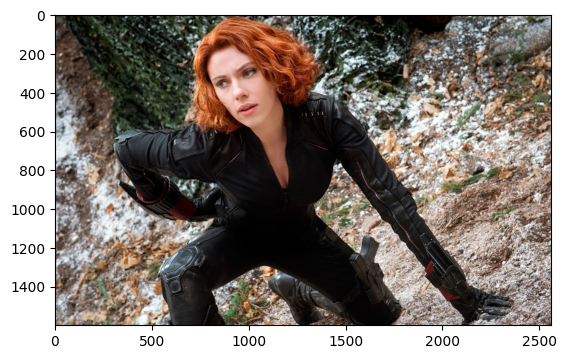

In [43]:
imd = "ScarJoh-DoubleCheck.jpg"
img = Image.open(imd)
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)
img_t = img_t.to(device)

output = ensemble_model(img_t)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(f"predictClass_name: {predictClass_name} \n")
      
output_softmax = torch.nn.functional.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    confidence_percentage = output_softmax[0][i] * 100
    print(f"Class: {class_name}, Confidence: {confidence_percentage:.2f}%")
    
image = imag.imread(imd)
plt.imshow(image)

#### Sandra Bullock
Mistaken with Natalie Portman, with Sandra Bullock in 1.45% is too low

tensor([9], device='cuda:0')
predictClass_name: Natalie Portman 

Class: Angelina Jolie, Confidence: 32.23%
Class: Brad Pitt, Confidence: 0.00%
Class: Denzel Washington, Confidence: 0.00%
Class: Hugh Jackman, Confidence: 0.00%
Class: Jennifer Lawrence, Confidence: 1.00%
Class: Johnny Depp, Confidence: 0.00%
Class: Kate Winslet, Confidence: 5.00%
Class: Leonardo DiCaprio, Confidence: 0.00%
Class: Megan Fox, Confidence: 1.99%
Class: Natalie Portman, Confidence: 58.28%
Class: Nicole Kidman, Confidence: 0.00%
Class: Robert Downey Jr, Confidence: 0.00%
Class: Sandra Bullock, Confidence: 1.45%
Class: Scarlett Johansson, Confidence: 0.00%
Class: Tom Cruise, Confidence: 0.04%
Class: Tom Hanks, Confidence: 0.00%
Class: Will Smith, Confidence: 0.00%


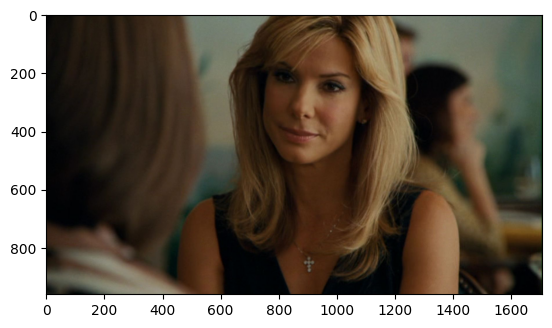

In [44]:
imd = "SandraBullock-DoubleCheck.jpg"
img = Image.open(imd)
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)
img_t = img_t.to(device)

output = ensemble_model(img_t)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(f"predictClass_name: {predictClass_name} \n")
      
output_softmax = torch.nn.functional.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    confidence_percentage = output_softmax[0][i] * 100
    print(f"Class: {class_name}, Confidence: {confidence_percentage:.2f}%")
    
image = imag.imread(imd)
plt.imshow(image)

#### Tom Hanks
Mistaken with Kate Winslet, second with with Brad Pitt. Atleast it's 3rd place

tensor([6], device='cuda:0')
predictClass_name: Kate Winslet 

Class: Angelina Jolie, Confidence: 0.00%
Class: Brad Pitt, Confidence: 34.93%
Class: Denzel Washington, Confidence: 0.00%
Class: Hugh Jackman, Confidence: 0.00%
Class: Jennifer Lawrence, Confidence: 0.00%
Class: Johnny Depp, Confidence: 0.00%
Class: Kate Winslet, Confidence: 63.81%
Class: Leonardo DiCaprio, Confidence: 0.16%
Class: Megan Fox, Confidence: 0.00%
Class: Natalie Portman, Confidence: 0.00%
Class: Nicole Kidman, Confidence: 0.00%
Class: Robert Downey Jr, Confidence: 0.14%
Class: Sandra Bullock, Confidence: 0.00%
Class: Scarlett Johansson, Confidence: 0.00%
Class: Tom Cruise, Confidence: 0.00%
Class: Tom Hanks, Confidence: 0.86%
Class: Will Smith, Confidence: 0.10%


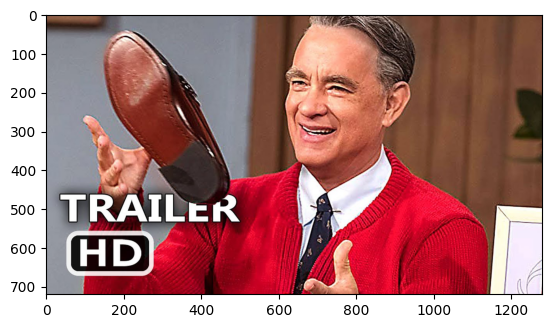

In [45]:
imd = "TomHanks-DoubleCheck.jpg"
img = Image.open(imd)
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)
img_t = img_t.to(device)

output = ensemble_model(img_t)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(f"predictClass_name: {predictClass_name} \n")
      
output_softmax = torch.nn.functional.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    confidence_percentage = output_softmax[0][i] * 100
    print(f"Class: {class_name}, Confidence: {confidence_percentage:.2f}%")
    
image = imag.imread(imd)
plt.imshow(image)

#### Megan Fox
It's pretty confident in Megan Fox, this could be good or just be the picture is in the dataset

tensor([8], device='cuda:0')
predictClass_name: Megan Fox 

Class: Angelina Jolie, Confidence: 0.00%
Class: Brad Pitt, Confidence: 0.00%
Class: Denzel Washington, Confidence: 0.00%
Class: Hugh Jackman, Confidence: 0.00%
Class: Jennifer Lawrence, Confidence: 0.00%
Class: Johnny Depp, Confidence: 0.00%
Class: Kate Winslet, Confidence: 0.05%
Class: Leonardo DiCaprio, Confidence: 0.00%
Class: Megan Fox, Confidence: 99.70%
Class: Natalie Portman, Confidence: 0.03%
Class: Nicole Kidman, Confidence: 0.00%
Class: Robert Downey Jr, Confidence: 0.00%
Class: Sandra Bullock, Confidence: 0.16%
Class: Scarlett Johansson, Confidence: 0.06%
Class: Tom Cruise, Confidence: 0.00%
Class: Tom Hanks, Confidence: 0.00%
Class: Will Smith, Confidence: 0.00%


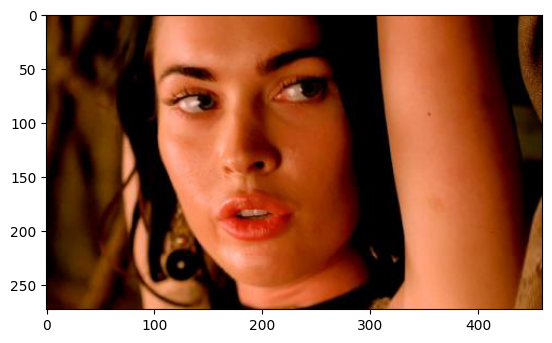

In [46]:
imd = "MeganFox-DoubleCheck.jpg"
img = Image.open(imd)
img_t = preprocess(img)
img_t = img_t.unsqueeze(0)
img_t = img_t.to(device)

output = ensemble_model(img_t)
predictClass = output.argmax(dim=1)
print(predictClass)
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
predictClass_name = class_names[predictClass.item()]
print(f"predictClass_name: {predictClass_name} \n")
      
output_softmax = torch.nn.functional.softmax(output, dim=1)

for i, class_name in enumerate(class_names):
    confidence_percentage = output_softmax[0][i] * 100
    print(f"Class: {class_name}, Confidence: {confidence_percentage:.2f}%")
    
image = imag.imread(imd)
plt.imshow(image)

In [56]:
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

def crop(img_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 4)
    cropped_faces = []
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        cropped_faces.append((face, (x, y, w, h)))  # Store face image and coordinates
    return img, cropped_faces

# Assuming your ensemble_model takes a list of face images as input
def predict_faces(face_images):
    predictions = []
    face_tensor = preprocess(face_images)
    face_tensor = face_tensor.unsqueeze(0).to(device)
    output = ensemble_model(face_tensor)
    predict_class = output.argmax(dim=1)
    class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]
    predicted_name = class_names[predict_class.item()]
    predictions.append(predicted_name)
    return predictions

# Load your image and crop faces
image_path = "MeganFox-DoubleCheck.jpg"
img, cropped_faces = crop(image_path)

# Predict and print results for each face
print(len(img))
predictions = predict_faces(cropped_faces)
print(predictions)
for i, prediction in enumerate(predictions):
    print(f"Prediction for face {i+1}: {prediction}")

# Display the original image with rectangles around detected faces
for _, (x, y, w, h) in cropped_faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

273


TypeError: Unexpected type <class 'list'>

In [ ]:
class_names = ["Angelina Jolie", "Brad Pitt", "Denzel Washington", "Hugh Jackman", "Jennifer Lawrence", "Johnny Depp", "Kate Winslet", "Leonardo DiCaprio", "Megan Fox", "Natalie Portman", "Nicole Kidman", "Robert Downey Jr", "Sandra Bullock", "Scarlett Johansson", "Tom Cruise", "Tom Hanks", "Will Smith"]